In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from glob import glob
from gbi_diff.utils.train_theta_noise_config import Config

tab10 = mpl.colormaps["tab10"]

In [2]:
dfs = []
for file_name in glob("results/theta_noise/two_moons/lightning_logs/version_*/*/*.csv"):
    df = pd.read_csv(file_name)
    config_path = "/".join(file_name.split("/")[:-2]) + "/config.yaml"
    config = Config.from_file(config_path)
    df["loss_sample_prob"] = config.diffusion.UniformSampler.p
    dfs.append(df)

df = pd.concat(dfs)

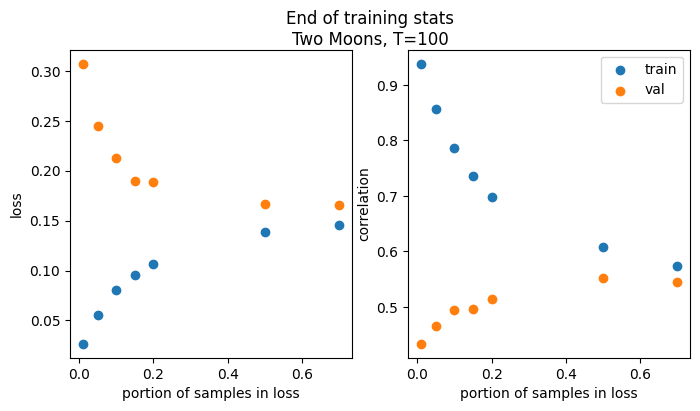

In [3]:
max_epochs = df[["epoch", "loss_sample_prob"]].groupby("loss_sample_prob").max()
max_epochs = max_epochs.reset_index()
max_epochs[max_epochs["epoch"] == 91] = 89  # add the aborted training run

query_str = " | ".join([f"(loss_sample_prob == {x} & epoch == {y})" for x, y in max_epochs.values])

filtered_df = df.query(query_str)

train_df = filtered_df[["loss_sample_prob", "train/loss", "train/cost_corr"]].dropna()
val_df = filtered_df[["loss_sample_prob", "val/loss", "val/cost_corr"]].dropna()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.scatter(train_df["loss_sample_prob"], train_df["train/loss"], label="train", color=tab10(0))
ax2.scatter(train_df["loss_sample_prob"], train_df["train/cost_corr"], label="train", color=tab10(0))
ax1.scatter(val_df["loss_sample_prob"], val_df["val/loss"], label="val", color=tab10(1))
ax2.scatter(val_df["loss_sample_prob"], val_df["val/cost_corr"], label="val", color=tab10(1))     

# ax1.set_xscale("log")
# ax2.set_xscale("log")

ax1.set_ylabel("loss")
ax2.set_ylabel("correlation")
ax1.set_xlabel("portion of samples in loss")
ax2.set_xlabel("portion of samples in loss")
fig.suptitle("End of training stats\nTwo Moons, T=100")
ax2.legend()